# Computer Vision

To work in this Colab notebook, first save a copy of it via "File" -> "Save a copy in Drive" in the top-left menu bar.


### 1. Install all missing packages that we need an download our custom FashionMNIST data

The data files will be available locally in your Colab runtime. You can find them through the files menu on the left.

In [ ]:
# Install packages
!pip install torchmetrics gdown

# Download training, validation, and test splits
!gdown https://drive.google.com/uc?id=1zYfBlExr_LK-Ld8rmxCTqRU5RAOUVVfh
!gdown https://drive.google.com/uc?id=1PJa_I3qG0P5whuARV_Se1_YUvHzR469R
!gdown https://drive.google.com/uc?id=1pC8-ummMGy1dPhHGPuNsms5_I7HpWgv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 13.8 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1zYfBlExr_LK-Ld8rmxCTqRU5RAOUVVfh
To: /content/fashion_mnist_training.pt
100% 3.93M/3.93M [00:00<00:00, 218MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PJa_I3qG0P5whuARV_Se1_YUvHzR469R
To: /content/fashion_mnist_validation.pt
100% 786k/786k [00:00<00:00, 96.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pC8-ummMGy1dPhHGPuNsms5_I7HpWgv2
To: /content/fashion_mnist_test.pt
100% 786k/786k [00:00<00:00, 171MB/s]


### 2. Import classes and functions we will be using

In [ ]:
import math
import os
import random
from typing import Any, Callable, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
from torchvision.transforms import Compose, Lambda, ToTensor
from torchvision.models.resnet import ResNet, BasicBlock
from torchmetrics.functional.classification import multiclass_confusion_matrix

### 3. Check which PyTorch version we are running and confirm that we are in a GPU runtime.
If this output shows that you are not in a GPU runtime, go to "Runtime" in the top-left menu bar -> "Change runtime type" -> set "Hardware Accelerator: GPU".

In [ ]:
print(f"Running PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
!nvidia-smi

Running PyTorch version: 2.0.0+cu118
CUDA available: True
Tue Apr  4 14:06:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                              

### 4. Make things (more) reproducible by setting random seeds

See here for details: https://pytorch.org/docs/stable/notes/randomness.html

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### 5. Define our custom IDS FashionMNIST PyTorch dataset

Our model inherits, i.e. is a specific kind of, `VisionDataset` in torchvision.\
This means it has all features defined in `VisionDataset`, unless they are explicitly overridden here, \
plus any additional functionality that may be defined below. You can read more about `VisionDataset` here: https://pytorch.org/vision/main/generated/torchvision.datasets.VisionDataset.html. 

In [ ]:
class IDSFashionMnistDataset(VisionDataset):
    """
    FashionMNIST dataset for the IDS course which loads custom data files from disk
    """
    
    classes = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]
    
    def __init__(
        self,
        root: str,
        split: str = "training",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        
        if not split in ["training", "validation", "test"]:
            raise ValueError("Split should be 'training', 'validation', or 'test'.")
            
        self.split = split
        self.root = root
        
        self.data, self.targets = self._load_data()
    
    def _load_data(self):
        data = torch.load(os.path.join(self.root, f"fashion_mnist_{self.split}.pt"))
        images = data[:, :-1].reshape(-1, 28, 28)  # 28x28 resolution
        labels = data[:, -1]
        return images, labels 
    
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target
    
    def __len__(self):
        return len(self.data)

### 6. Define our custom ResNet-18 model for FashionMNIST
The original ResNet-18 uses 3-channel (RGB) inputs and has 1000 output classes based on ImageNet-1K.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

We instead use single-channel inputs (Grayscale) and 10 output classes according to FashionMNIST.

In [ ]:
class FashionMnistResNet18(ResNet):
    """
    Custom ResNet-18 model which uses 1 input channel (grayscale) and has 10 output classes
    """
    def __init__(self):
        super().__init__(BasicBlock, [2,2,2,2,2], num_classes=10)
        self.conv1 = nn.Conv2d(1, 64,
          kernel_size=(7, 7),
          stride=(2, 2),
          padding=(3, 3),
          bias=False
        )

### 7. Load our custom FashionMNIST data

Here, we load our data using the `IDSFashionMnistDataset` class defined above. We also make use of the functionality in torchvision's `VisionDataset`, which `IDSFashionMnistDataset` inherits from, to set the transformations we want to apply when retrieving examples from our dataset. We use the `transform` keyword argument for this and compose our transformations using torchvision's `Compose` (https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html). In our base setting, the only transformation we apply is `ToTensor`, which converts our `PIL.Image` inputs into PyTorch tensors.

In [ ]:
# Create base transformation for our dataset
# TODO: how can these be modified to randomly flip examples?
base_transform = Compose([
    ToTensor(),
])

# Load datasets
train_dataset = IDSFashionMnistDataset(".", "training", transform=base_transform)
validation_dataset = IDSFashionMnistDataset(".", "validation", transform=base_transform)
test_dataset = IDSFashionMnistDataset(".", "test", transform=base_transform)

# Check the sizes of our datasets
print(f"Training dataset length = {len(train_dataset)}")
print(f"Validation dataset length = {len(validation_dataset)}")
print(f"Test dataset length = {len(test_dataset)}")

Training dataset length = 5000
Validation dataset length = 1000
Test dataset length = 1000


### 8. Implement our evaluation function and training loop

Below, we provide some rudimentary functionality for training and evaluation,\
as well as metric storing and logging, for our experiments.

In [ ]:
def log_metrics(metrics: dict, step: Optional[int] = None):
    """
    Log metrics stored in a dictionary
    """

    # During training, it can be useful to also log the current step
    if step is not None:
        print(f"\nMetrics step {step}:")

    for k, v in metrics.items():
        # We ignore the confusion matrix when logging metrics
        if not k.endswith("conf_matrix"):
            print(f"  {k}: {v}")

def evaluate(model, eval_dataloader, prefix="eval"):
    """
    Evaluation function that computes the loss, accuracy, and confusion matrix for the dataset
    passed via the `eval_dataloader` argument
    """
    
    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Move model to GPU
    model.cuda()

    # Set model to evaluation mode (e.g. to disable dropout)
    model.eval()

    eval_loss = 0
    y_pred = None
    y_true = None
    num_classes = None
    
    for batch_idx, batch in enumerate(tqdm(eval_dataloader, desc=f"Evaluating")):
        # Loop over batches in dataloader
        
        # Move batch to GPU
        inputs, labels = batch
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        # Use no_grad mode to disable gradient computation
        with torch.no_grad():
            # Get model outputs
            outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        eval_loss += loss.detach().cpu().item()

        if num_classes is None:
            num_classes = len(outputs[0])
        
        # Get class predictions
        preds = torch.argmax(outputs, dim=-1)
        
        # Accumulate predictions and true classes over batches
        y_pred = torch.cat([y_pred, preds]) if y_pred is not None else preds
        y_true = torch.cat([y_true, labels]) if y_true is not None else labels

    
    # Move predictions and true classes back to CPU
    y_pred = y_pred.detach().cpu()
    y_true = y_true.detach().cpu()
  
    # Compute metrics
    eval_loss /= len(eval_dataloader)
    eval_acc = (y_pred == y_true).sum() / len(y_true)
    eval_conf_matrix = multiclass_confusion_matrix(
        y_pred, y_true, num_classes=num_classes
    )
    
    # Store metrics in a dictionary
    metrics = {
        f"{prefix}_loss": eval_loss,
        f"{prefix}_accuracy": eval_acc.item(),
        f"{prefix}_conf_matrix": eval_conf_matrix.numpy()
    }

    return metrics


def save_best_model(model: nn.Module):
  """
  Simple function that saves the weights of the specified model to disk.
  We use this to keep track of the best model (based on validation loss).
  """
  output_path = "best_model.pt"
  torch.save(model.state_dict(), output_path)
  print(f"Saved new best model to {output_path}\n")


def load_best_model(model: nn.Module, model_path: str = "best_model.pt"):
  """
  Simple function that loads model weights stored at `model_path` into the 
  passed model of type `nn.Module`. We use this to load our best model checkpoint.
  """
  model.load_state_dict(torch.load(model_path))
  model.eval()
  print(f"Loaded best {model.__class__.__name__} model from {model_path}\n")
  return model


def train(
  model: nn.Module,
  train_dataloader: DataLoader,
  eval_dataloader: DataLoader,
  num_epochs: int = 20,
  lr: float = 0.1,
  eval_steps: int = 100
):
    """
    Training loop
    """
    
    # Create SGD optimizer with specified learning rate and fixed momentum
    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)
    
    # Create linear learning rate decay schedule
    scheduler = LinearLR(
        optimizer,
        start_factor=1.0,
        end_factor=1e-6,
        total_iters=len(train_dataloader) * num_epochs
    )
    
    # Define loss function
    criterion = nn.CrossEntropyLoss()
    
    # Move model to GPU
    model.cuda()

    total_loss = 0
    total_eval_loss = 0
    global_step = 0
    global_eval_step = 0
    best_eval_loss = float("inf")

    # Store our initial model
    save_best_model(model)

    # Create dictionary to store metrics throughout training
    metrics_dict = {}

    print("Starting model training")

    for epoch_idx in range(num_epochs):
        # Epoch loop (one epoch is one pass over the full training dataset)
        
        for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch_idx+1}")):
            # Loop over batches in training dataset
            
            # Set model to training mode
            model.train()

            global_step += 1
            
            # Move batch to GPU
            inputs, labels = batch
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            # Get model outputs
            outputs = model(inputs)
            
            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.detach().cpu().item()
            
            # Evaluation loop
            if global_step % eval_steps == 0:
                global_eval_step += 1
                metrics = {
                    "mean_train_loss": total_loss / global_step,
                    "learning_rate": scheduler.get_last_lr()[0]
                }

                # Evaluate on validation and training datasets
                metrics.update(evaluate(model, eval_dataloader, prefix="eval"))
                metrics.update(evaluate(model, train_dataloader, prefix="train"))

                # Update and log metrics
                total_eval_loss += metrics["eval_loss"]
                metrics["mean_eval_loss"] = total_eval_loss / global_eval_step
                log_metrics(metrics, step=global_step)
                metrics_dict[global_step] = metrics
            
                # Check if our validation loss has decreased, and if so,
                # update our best model checkpoint
                if metrics["eval_loss"] <= best_eval_loss:
                  best_eval_loss = metrics["eval_loss"]
                  save_best_model(model)

            # Compute gradients
            loss.backward()
            
            # Perform update step
            optimizer.step()
            
            # Reduce learning rate for stability
            scheduler.step()
            
            # Set gradients to zero
            model.zero_grad()

    return metrics_dict

### 9. Define hyperparameters, create dataloaders, instantiate model, and run training/evaluation procedure

Here, we set our hyper-parameters for the dataloader (batch size) and the training loop \
(number of epochs, learning rate, and evaluation interval in steps).

We only use very basic data loading functionality. More information on available features can be found here https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader.

In [ ]:
# TODO: set your hyperparameters
bs = 256
num_epochs = 100
lr = 0.1
eval_steps = 100

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=bs, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

# Instantiate a new model
model = FashionMnistResNet18()

# Train model and save training and evaluation metrics
metrics_dict = train(
    model, train_dataloader, validation_dataloader, num_epochs=num_epochs, lr=lr, eval_steps=eval_steps
)

Saved new best model to best_model.pt

Starting model training


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 22.88it/s]

Epoch 5: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]



Metrics step 100:
  mean_train_loss: 0.8804438790678978
  learning_rate: 0.09505000494999999
  eval_loss: 0.5439412891864777
  eval_accuracy: 0.7960000038146973
  train_loss: 0.5247706577181817
  train_accuracy: 0.8041999936103821
  mean_eval_loss: 0.5439412891864777
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 24.71it/s]

Epoch 10: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]



Metrics step 200:
  mean_train_loss: 0.6509638403356075
  learning_rate: 0.09005000994999993
  eval_loss: 0.4443496838212013
  eval_accuracy: 0.8360000252723694
  train_loss: 0.2889821998775005
  train_accuracy: 0.8899999856948853
  mean_eval_loss: 0.4941454865038395
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 24.08it/s]

Epoch 15: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s]



Metrics step 300:
  mean_train_loss: 0.5255318001906077
  learning_rate: 0.08505001494999989
  eval_loss: 0.49174559116363525
  eval_accuracy: 0.8349999785423279
  train_loss: 0.19732943698763847
  train_accuracy: 0.9228000044822693
  mean_eval_loss: 0.4933455213904381


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 14.62it/s]

Epoch 20: 100%|██████████| 20/20 [00:02<00:00,  8.06it/s]



Metrics step 400:
  mean_train_loss: 0.43746212860569356
  learning_rate: 0.08005001994999977
  eval_loss: 0.5699669718742371
  eval_accuracy: 0.8379999995231628
  train_loss: 0.1649846389889717
  train_accuracy: 0.9366000294685364
  mean_eval_loss: 0.5125008840113878


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 24.04it/s]

Epoch 25: 100%|██████████| 20/20 [00:01<00:00, 10.42it/s]



Metrics step 500:
  mean_train_loss: 0.37248121920228006
  learning_rate: 0.07505002494999956
  eval_loss: 0.6340919733047485
  eval_accuracy: 0.8370000123977661
  train_loss: 0.07892280630767345
  train_accuracy: 0.9714000225067139
  mean_eval_loss: 0.53681910187006


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.82it/s]

Epoch 30: 100%|██████████| 20/20 [00:02<00:00,  7.36it/s]



Metrics step 600:
  mean_train_loss: 0.32206037590590614
  learning_rate: 0.07005002994999944
  eval_loss: 0.7467600554227829
  eval_accuracy: 0.8429999947547913
  train_loss: 0.06489175353199243
  train_accuracy: 0.9747999906539917
  mean_eval_loss: 0.5718092607955138


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 24.21it/s]

Epoch 35: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]



Metrics step 700:
  mean_train_loss: 0.28259429991378315
  learning_rate: 0.06505003494999935
  eval_loss: 0.7173846811056137
  eval_accuracy: 0.843999981880188
  train_loss: 0.059738493897020815
  train_accuracy: 0.9760000109672546
  mean_eval_loss: 0.5926057494112423


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 16.36it/s]

Epoch 40: 100%|██████████| 20/20 [00:02<00:00,  7.23it/s]



Metrics step 800:
  mean_train_loss: 0.25012431842566
  learning_rate: 0.06005003994999934
  eval_loss: 0.8025693148374557
  eval_accuracy: 0.8489999771118164
  train_loss: 0.006688848591875285
  train_accuracy: 0.9983999729156494
  mean_eval_loss: 0.618851195089519


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 22.13it/s]

Epoch 45: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]



Metrics step 900:
  mean_train_loss: 0.22523240307734038
  learning_rate: 0.055050044949999356
  eval_loss: 0.8816470950841904
  eval_accuracy: 0.8370000123977661
  train_loss: 0.04307649307884276
  train_accuracy: 0.9850000143051147
  mean_eval_loss: 0.6480507395333714


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 17.54it/s]

Epoch 50: 100%|██████████| 20/20 [00:02<00:00,  7.26it/s]



Metrics step 1000:
  mean_train_loss: 0.20365221380704315
  learning_rate: 0.050050049949999446
  eval_loss: 0.8938196301460266
  eval_accuracy: 0.8510000109672546
  train_loss: 0.0010898572363657877
  train_accuracy: 0.9998000264167786
  mean_eval_loss: 0.6726276285946369


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 22.45it/s]

Epoch 55: 100%|██████████| 20/20 [00:02<00:00,  7.38it/s]



Metrics step 1100:
  mean_train_loss: 0.18521478399044347
  learning_rate: 0.045050054949999536
  eval_loss: 0.9317511916160583
  eval_accuracy: 0.8489999771118164
  train_loss: 0.00024011193527258002
  train_accuracy: 1.0
  mean_eval_loss: 0.6961843161420389


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 13.97it/s]

Epoch 60: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]



Metrics step 1200:
  mean_train_loss: 0.16980922523300251
  learning_rate: 0.04005005994999966
  eval_loss: 0.9577929228544235
  eval_accuracy: 0.8489999771118164
  train_loss: 0.00014826229962636717
  train_accuracy: 1.0
  mean_eval_loss: 0.717985033368071


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 23.68it/s]

Epoch 65: 100%|██████████| 20/20 [00:01<00:00, 10.28it/s]



Metrics step 1300:
  mean_train_loss: 0.15676708518551516
  learning_rate: 0.03505006494999977
  eval_loss: 0.9667696952819824
  eval_accuracy: 0.8489999771118164
  train_loss: 0.00011745157280529384
  train_accuracy: 1.0
  mean_eval_loss: 0.7371223150537565


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 14.85it/s]

Epoch 70: 100%|██████████| 20/20 [00:02<00:00,  7.73it/s]



Metrics step 1400:
  mean_train_loss: 0.14558868672715367
  learning_rate: 0.030050069949999845
  eval_loss: 0.9719131886959076
  eval_accuracy: 0.8450000286102295
  train_loss: 0.00010870374135265592
  train_accuracy: 1.0
  mean_eval_loss: 0.7538930917424815


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 24.11it/s]

Epoch 75: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]



Metrics step 1500:
  mean_train_loss: 0.13589610588620415
  learning_rate: 0.025050074949999862
  eval_loss: 0.9801001101732254
  eval_accuracy: 0.8479999899864197
  train_loss: 9.353074165119324e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.7689735596378644


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 15.36it/s]

Epoch 80: 100%|██████████| 20/20 [00:02<00:00,  7.56it/s]



Metrics step 1600:
  mean_train_loss: 0.12741339836298948
  learning_rate: 0.02005007994999987
  eval_loss: 0.9933845698833466
  eval_accuracy: 0.8510000109672546
  train_loss: 8.023762256925693e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.7829992477782071


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 22.76it/s]

Epoch 85: 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]



Metrics step 1700:
  mean_train_loss: 0.1199283488988337
  learning_rate: 0.015050084949999864
  eval_loss: 0.99695685505867
  eval_accuracy: 0.847000002861023
  train_loss: 7.425856638292317e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.7955849893829402


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 15.86it/s]

Epoch 90: 100%|██████████| 20/20 [00:02<00:00,  7.77it/s]



Metrics step 1800:
  mean_train_loss: 0.11327465668123801
  learning_rate: 0.010050089949999917
  eval_loss: 1.0007636100053787
  eval_accuracy: 0.8479999899864197
  train_loss: 7.161902067309711e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8069838016397424


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 22.98it/s]

Epoch 95: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]



Metrics step 1900:
  mean_train_loss: 0.10732132748916276
  learning_rate: 0.005050094949999962
  eval_loss: 1.00564406812191
  eval_accuracy: 0.8489999771118164
  train_loss: 6.896052400406916e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8174396051388038


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 16.80it/s]

Epoch 100: 100%|██████████| 20/20 [00:02<00:00,  7.51it/s]


Metrics step 2000:
  mean_train_loss: 0.10196282780616094
  learning_rate: 5.009994999999962e-05
  eval_loss: 1.0154532194137573
  eval_accuracy: 0.8450000286102295
  train_loss: 6.456808550865389e-05
  train_accuracy: 1.0
  mean_eval_loss: 0.8273402858525515


### 10. Load our saved best model checkpoint
 
We can make use of the `load_best_model` function defined above to quickly load \
the best model checkpoint for further evaluation.

You can find more information on saving and loading model weights at

https://pytorch.org/tutorials/beginner/saving_loading_models.html.

In [ ]:
best_model = load_best_model(FashionMnistResNet18())

Loaded best FashionMnistResNet18 model from best_model.pt



In [ ]:
best_model

FashionMnistResNet18(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(in

### 11. Evaluate your best model and visualize the confusion matrix

TODO: You should implement this yourself using the functions defined above.

In [ ]:
# TODO
e = evaluate(best_model,test_dataloader)


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 19.92it/s]


In [ ]:
e['eval_conf_matrix']

array([[ 74,   0,   1,   8,   1,   0,  11,   0,   0,   0],
       [  0,  97,   1,   5,   0,   0,   2,   0,   0,   0],
       [  1,   0,  79,   1,  15,   0,   6,   0,   1,   0],
       [  2,   3,   2,  81,   4,   0,   4,   0,   0,   0],
       [  0,   0,   8,   4,  72,   0,   4,   0,   0,   0],
       [  0,   0,   0,   0,   0, 104,   0,   6,   0,   1],
       [ 17,   0,  19,   4,  14,   0,  43,   0,   2,   0],
       [  0,   0,   0,   1,   0,   3,   0,  91,   0,   3],
       [  0,   0,   1,   0,   0,   2,   1,   0, 106,   0],
       [  0,   0,   0,   0,   0,   0,   0,  14,   0,  81]])

<Axes: >

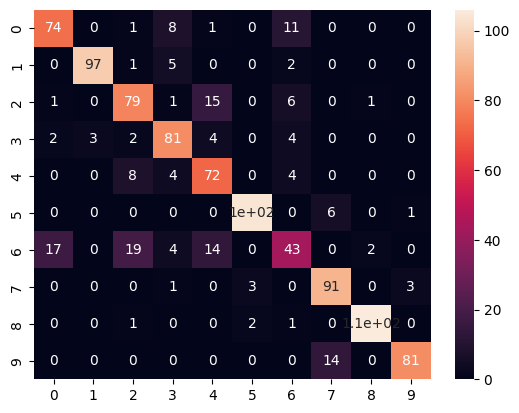

In [ ]:
sns.heatmap(e['eval_conf_matrix'], annot=True)

### 12. Plot your loss curves

TODO: You should implement this yourself. Use the `metrics_dict` returned by the training loop.

In [ ]:
metrics_dict

{100: {'mean_train_loss': 0.8804438790678978,
  'learning_rate': 0.09505000494999999,
  'eval_loss': 0.5439412891864777,
  'eval_accuracy': 0.7960000038146973,
  'eval_conf_matrix': array([[ 73,   0,   2,   2,   0,   0,   8,   0,   1,   0],
         [  0, 100,   0,   3,   0,   0,   3,   0,   0,   0],
         [  2,   0,  61,   0,  22,   0,  28,   0,   1,   0],
         [  4,   1,   0,  80,   4,   0,   5,   0,   1,   0],
         [  0,   0,   5,   4,  74,   0,   8,   0,   0,   0],
         [  0,   0,   0,   0,   0,  80,   0,  10,   2,   1],
         [ 18,   0,  16,   2,  22,   0,  32,   0,   3,   0],
         [  0,   0,   0,   0,   0,   4,   0,  92,   0,   4],
         [  0,   0,   0,   0,   1,   0,   2,   0, 108,   0],
         [  0,   0,   0,   0,   0,   1,   0,  14,   0,  96]]),
  'train_loss': 0.5247706577181817,
  'train_accuracy': 0.8041999936103821,
  'train_conf_matrix': array([[422,   0,   9,  23,   5,   0,  42,   0,  19,   0],
         [  0, 428,   6,  15,   0,   0,   7,   0, 

In [ ]:
# TODO
loss_list =[]
metrics_dict
for num in metrics_dict.keys():
#   print(num, metrics_dict[num]['mean_train_loss'],metrics_dict[num]['mean_eval_loss'])
   loss_list.append((num, metrics_dict[num]['mean_train_loss'],metrics_dict[num]['mean_eval_loss']))
df1 = pd.DataFrame(loss_list, columns =['number','mean_train_loss','mean_eval_loss'])
#sns.lineplot(data=df1, x= df1["number"], y=df1['mean_train_loss'],color = "red")
#sns.lineplot(data=df1, x= df1["number"], y=df1['mean_eval_loss'],color = "blue")


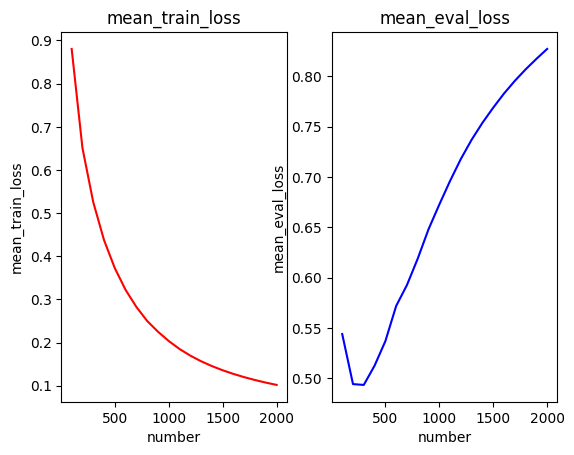

In [ ]:
plt.subplot(1, 2, 1) # row 1, col 2 index 1
sns.lineplot(data=df1, x= df1["number"], y=df1['mean_train_loss'],color = "red")
plt.title("mean_train_loss")

plt.subplot(1, 2, 2) # index 2
sns.lineplot(data=df1, x= df1["number"], y=df1['mean_eval_loss'],color = "blue")
plt.title("mean_eval_loss")
plt.show()

### 12. Plot your accuracy curves

TODO: You should implement this yourself. Use the `metrics_dict` returned by the training loop.

<ipython-input-18-bbc81feeae95>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1) # row 1, col 2 index 1


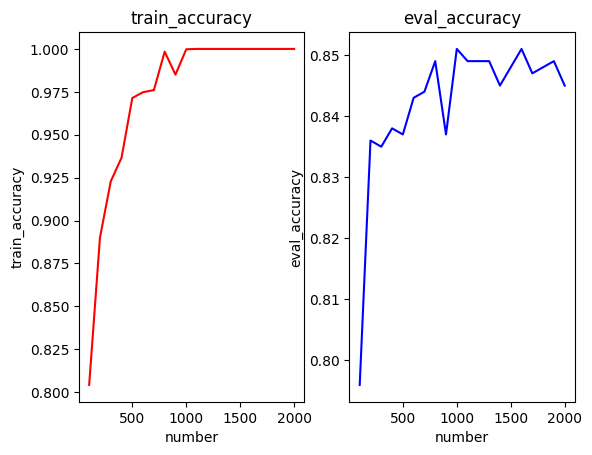

In [ ]:
# TODO
acc_list =[]
metrics_dict
for num in metrics_dict.keys():
#   print(num, metrics_dict[num]['eval_accuracy'],metrics_dict[num]['train_accuracy'])
    acc_list.append((num, metrics_dict[num]['eval_accuracy'],metrics_dict[num]['train_accuracy']))
    
df2 = pd.DataFrame(acc_list, columns =['number','eval_accuracy','train_accuracy'])
sns.lineplot(data=df2[['eval_accuracy', 'train_accuracy']])

plt.subplot(1, 2, 1) # row 1, col 2 index 1
sns.lineplot(data=df2, x= df2["number"], y=df2['train_accuracy'],color = "red")
plt.title("train_accuracy")

plt.subplot(1, 2, 2) # index 2
sns.lineplot(data=df2, x= df2["number"], y=df2['eval_accuracy'],color = "blue")
plt.title("eval_accuracy")
plt.show()

In [ ]:
RandomHorizontalFlip([p])

NameError: ignored

In [ ]:
#confusion plot
e['eval_conf_matrix']

array([[ 74,   0,   1,   8,   1,   0,  11,   0,   0,   0],
       [  0,  97,   1,   5,   0,   0,   2,   0,   0,   0],
       [  1,   0,  79,   1,  15,   0,   6,   0,   1,   0],
       [  2,   3,   2,  81,   4,   0,   4,   0,   0,   0],
       [  0,   0,   8,   4,  72,   0,   4,   0,   0,   0],
       [  0,   0,   0,   0,   0, 104,   0,   6,   0,   1],
       [ 17,   0,  19,   4,  14,   0,  43,   0,   2,   0],
       [  0,   0,   0,   1,   0,   3,   0,  91,   0,   3],
       [  0,   0,   1,   0,   0,   2,   1,   0, 106,   0],
       [  0,   0,   0,   0,   0,   0,   0,  14,   0,  81]])

In [ ]:
dff = pd.DataFrame(e['eval_conf_matrix'],columns=['0 T-shirt/top','1 Trouser','2 Pullover','3 Dress','4 Coat','5 Sandal','6 Shirt','7 Sneaker','8 Bag','9 Ankle boot'])
#sns.heatmap(e['eval_conf_matrix'], annot=True)
dff

,0 T-shirt/top,1 Trouser,2 Pullover,3 Dress,4 Coat,5 Sandal,6 Shirt,7 Sneaker,8 Bag,9 Ankle boot
0,74,0,1,8,1,0,11,0,0,0
1,0,97,1,5,0,0,2,0,0,0
2,1,0,79,1,15,0,6,0,1,0
3,2,3,2,81,4,0,4,0,0,0
4,0,0,8,4,72,0,4,0,0,0
5,0,0,0,0,0,104,0,6,0,1
6,17,0,19,4,14,0,43,0,2,0
7,0,0,0,1,0,3,0,91,0,3
8,0,0,1,0,0,2,1,0,106,0
9,0,0,0,0,0,0,0,14,0,81


<Axes: >

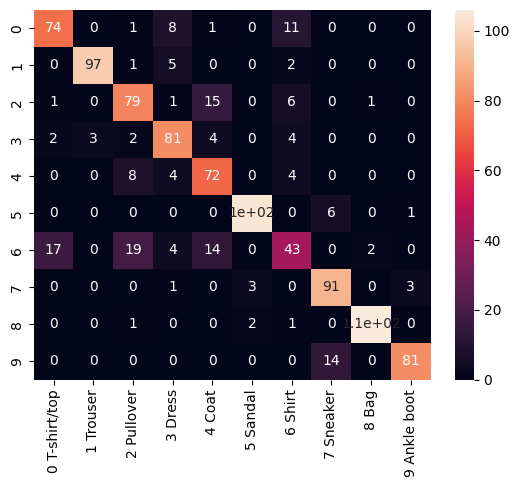

In [ ]:
sns.heatmap(dff, annot=True)